In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs

signnames.csv test.p        train.p       valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import pickle
import pandas as pd
import random

In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]),'The number of images != the number of labels'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images != the number of labels'
assert(X_train.shape[1] == X_test.shape[1]), 'The number of images != the number of labels'
assert(X_train.shape[1:] == (32,32,3)), 'the dimensions of the images are not 32x32x3'
assert(X_val.shape[1:] == (32,32,3)), 'the dimensions of the images are not 32x32x3'
assert(X_test.shape[1:] == (32,32,3)), 'the dimensions of the images are not 32x32x3'

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data.head())

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


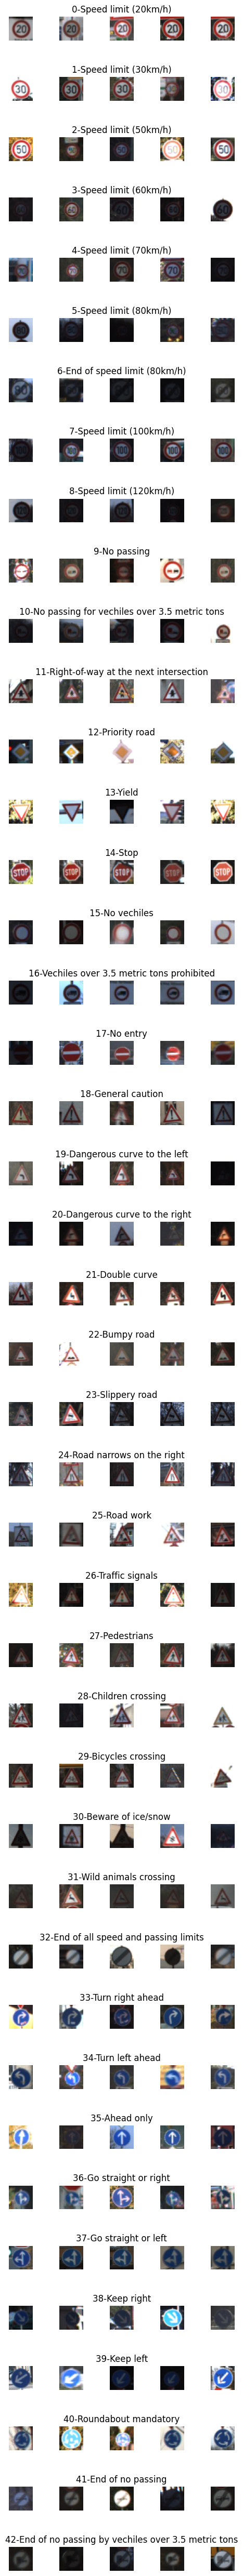

In [9]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["SignName"])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

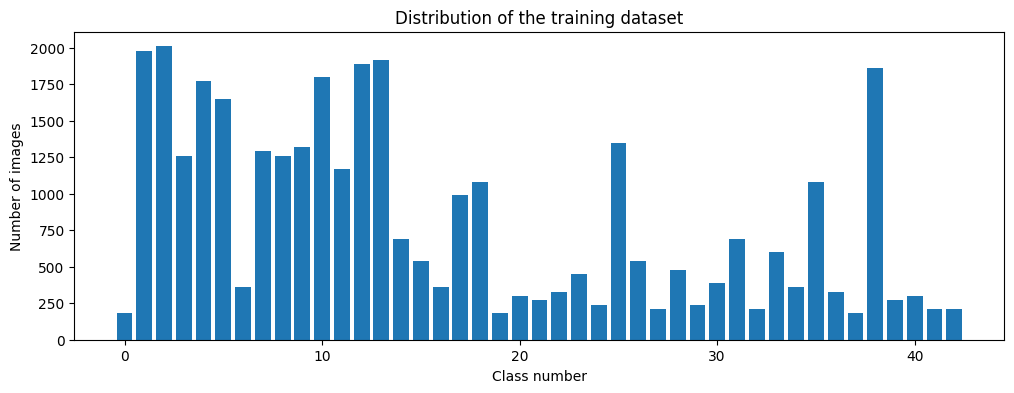

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## image preprocessing

(32, 32, 3)
Go straight or right


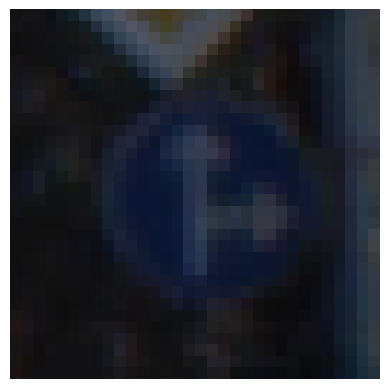

In [11]:
import cv2

i_ = 1000
plt.imshow(X_train[i_])
plt.axis("off")
print(X_train[i_].shape)
print(data['SignName'][y_train[i_]])

(32, 32)


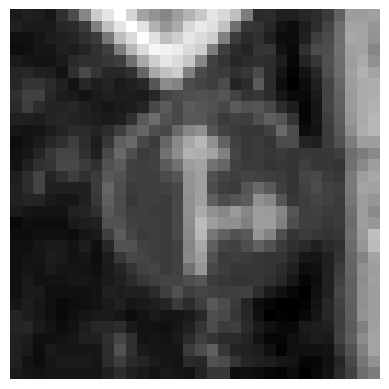

In [12]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[i_])
plt.imshow(img,cmap='gray')
plt.axis("off")
print(img.shape)

(32, 32)


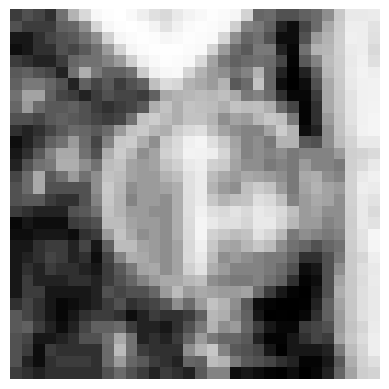

In [13]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img,cmap='gray')
plt.axis("off")
print(img.shape)

In [14]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(32, 32)


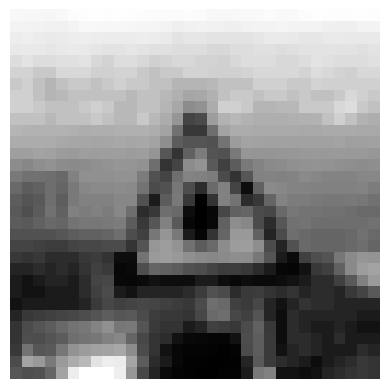

In [15]:
i_ = random.randint(0,len(X_train)-1)
plt.imshow(X_train[i_],cmap='gray')
plt.axis("off")
print(X_train[i_].shape)

In [16]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [17]:
# to generate artificially more data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.2,
                              shear_range=0.1,
                              rotation_range=10)
datagen.fit(X_train)

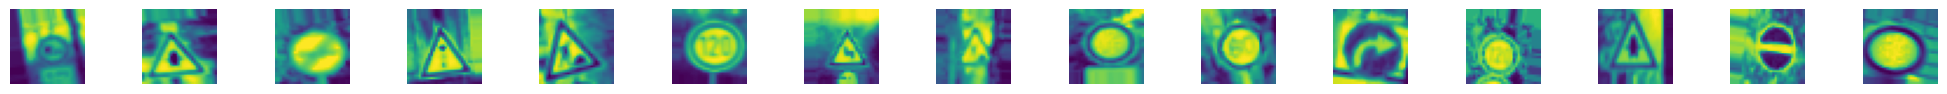

In [18]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [20]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

# Create conv. NN

In [21]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [22]:
model = modified_model()
print(model.summary())

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                      

2024-10-28 14:56:21.684703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-28 14:56:21.684892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
X_train.shape

(34799, 32, 32, 1)

In [24]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                              #steps_per_epoch=2000,
                              epochs=10,
                              validation_data=(X_val, y_val),
                              shuffle=1)

Epoch 1/10


2024-10-28 14:56:21.921254: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-28 14:56:22.348254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


694/696 [============================>.] - ETA: 0s - loss: 1.7079 - accuracy: 0.5134

2024-10-28 14:56:39.163570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


696/696 [==============================] - 19s 26ms/step - loss: 1.7052 - accuracy: 0.5142 - val_loss: 0.3687 - val_accuracy: 0.8741
Epoch 2/10
696/696 [==============================] - 17s 25ms/step - loss: 0.5387 - accuracy: 0.8362 - val_loss: 0.1127 - val_accuracy: 0.9685
Epoch 3/10
696/696 [==============================] - 17s 24ms/step - loss: 0.3177 - accuracy: 0.9029 - val_loss: 0.0988 - val_accuracy: 0.9683
Epoch 4/10
696/696 [==============================] - 17s 25ms/step - loss: 0.2380 - accuracy: 0.9241 - val_loss: 0.0802 - val_accuracy: 0.9755
Epoch 5/10
696/696 [==============================] - 17s 24ms/step - loss: 0.1928 - accuracy: 0.9411 - val_loss: 0.0521 - val_accuracy: 0.9846
Epoch 6/10
696/696 [==============================] - 17s 24ms/step - loss: 0.1577 - accuracy: 0.9506 - val_loss: 0.0599 - val_accuracy: 0.9832
Epoch 7/10
696/696 [==============================] - 17s 25ms/step - loss: 0.1490 - accuracy: 0.9543 - val_loss: 0.0569 - val_accuracy: 0.9837
Epo

Text(0.5, 0, 'epoch')

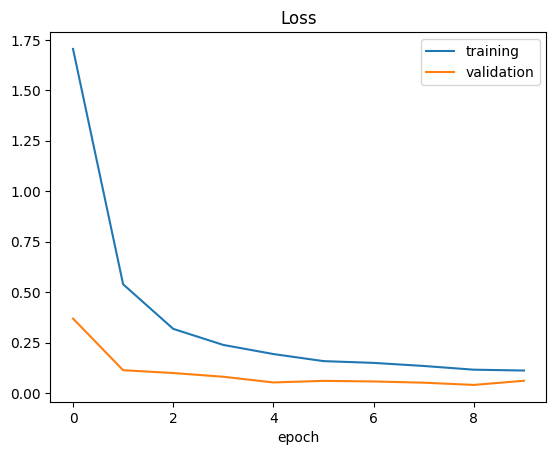

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

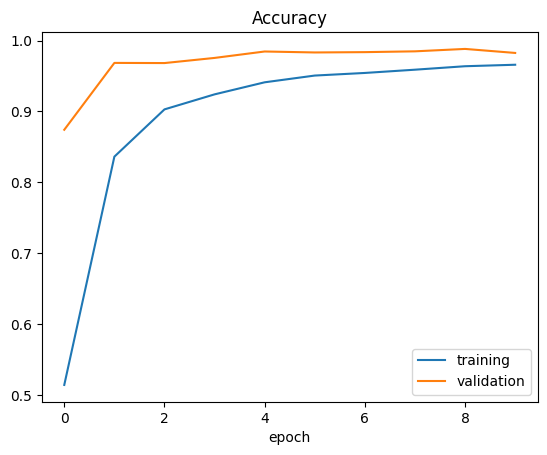

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [33]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.19050166010856628
Test accuracy: 0.9535233378410339


# Model testing

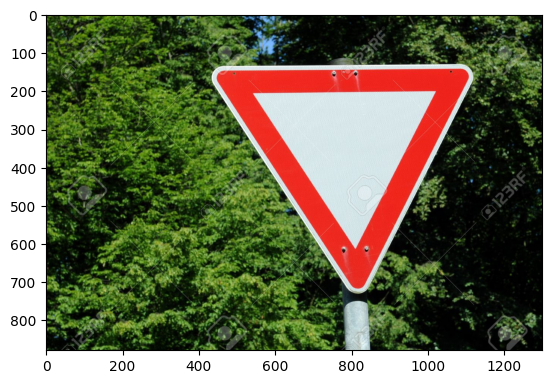

In [34]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


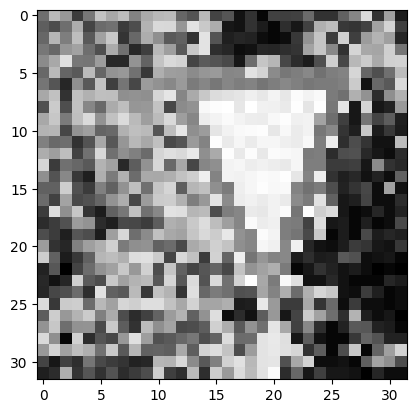

In [35]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

img = img.reshape(1, 32, 32, 1)

In [36]:
#Test image
prediction = np.argmax(model.predict(img))
print("predicted sign: "+ str(prediction)+', ', data["SignName"][prediction])

1/1 [==============================] - 0s 32ms/step
predicted sign: 13,  Yield
